# Predicting the functional status of public water pumps in Tanzania

In [35]:
# to print all outputs in a cell instead of just the last one 
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = 'all'  # 'last_expr' to revert to default behaviour 

# import
import numpy as np
import pandas as pd

# visualisation
import matplotlib.pyplot as plt
#set figure size
plt.rcParams['figure.figsize'] = 9, 6
import seaborn as sns
sns.set_style('whitegrid')   

# to build specific estimators
from sklearn.base import BaseEstimator, TransformerMixin

#from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
#from sklearn.tree import DecisionTreeClassifier 
#from sklearn.metrics import f1_score

# to display all columns of dataframe 
pd.set_option('display.max_columns', 50)

In [2]:
# read data files
train_predictors = pd.read_csv('./input/training_X.csv')
train_target = pd.read_csv('./input/training_y.csv')
# create dataset with both label and independent variables
train_set = pd.concat([train_target[['status_group']], train_predictors], axis=1, sort=False)

## EDA
59400 observations x  40 features

In [3]:
print('Dimensions of training set = {:d} observations x  {:d} features'.format(train_predictors.shape[0], train_predictors.shape[1]))
train_set.sample(3)

Dimensions of training set = 59400 observations x  40 features


,status_group,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
8246,functional,56151,0.0,2011-03-25,Lvia,0,commu,36.406365,-6.211546,Kwa Foibe,0,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Kongwa Urban,0,True,GeoData Consultants Ltd,VWC,Mlan,False,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
3652,non functional,51717,1.0,2011-03-13,District Council,-20,DWE,38.977494,-5.427067,Kwa Mama Songoro,0,Pangani,Malindi,Tanga,4,5,Pangani,Pangani Mashariki,3000,False,GeoData Consultants Ltd,VWC,NaN,False,1963,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
51232,non functional,30914,0.0,2012-10-17,World Vision,0,Consuting Engineer,33.018337,-4.160917,Mbugani Nzega Mpya,0,Internal,Nzega Mpya,Tabora,14,1,Nzega,Itobo,0,False,GeoData Consultants Ltd,VWC,NaN,False,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,seasonal,seasonal,shallow well,shallow well,groundwater,other,other


### Target

In [4]:
train_set['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

### Independant variables

Several categorical variables have missing values: funder, installer, subvillage, public meeting, scheme_management and scheme_name, permit.  
There is apparently no missing values for numerical variables.  
The variables *id* (id of each pump) and *recorded_by* (only one distinct value) have no explicative value and can ignored. 

In [5]:
summary = pd.DataFrame(np.array([train_predictors.dtypes, 
                                 train_predictors.isnull().sum(), 
                                 train_predictors.nunique()]),
                       index=['Dtype', 'NbrNullValues', 'NbrDistinctVal'],                                 
                       columns=np.array(list(train_predictors)))
display(summary)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
Dtype,int64,float64,object,object,int64,object,float64,float64,object,int64,object,object,object,int64,int64,object,object,int64,object,object,object,object,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
NbrNullValues,0,0,0,3635,0,3655,0,0,0,0,0,371,0,0,0,0,0,0,3334,0,3877,28166,3056,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NbrDistinctVal,59400,98,356,1897,2428,2145,57516,57517,37400,65,9,19287,21,27,20,125,2092,1049,2,1,12,2696,2,55,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6


### Numerical variables

Several numerical variables preset a high number of 0 values, which probably corresponds to missing value.

In [17]:
# extract all numerical variables plus target
train_num = train_predictors.select_dtypes(include=np.number)
train_num = pd.concat([train_num, train_target], axis=1)
train_num = train_num.drop(labels='id', axis=1)

train_num.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [91]:
# define here function to do some eda on numerical variables
def eda_numerical_variable(col, transform='none'):
    # create df and add column coding for 0 value
    df = train_num[['status_group',col]].copy()
    df['is_zero'] = (train_num[col] == 0)

    # frequency of 0 value
    print('NUMERICAL VARIABLE: ' + col)
    print('percentage of 0 value = {:.2f}%'.format(df[df.is_zero == True].shape[0]/train_num.shape[0]*100))

    # is distribution of label values different between variable group with 0 or non-0 value?
    print('\nDistribution of label values for predictor with NON-ZERO value')
    display(df.loc[df.is_zero == False, 'status_group'].value_counts(normalize=True))
    print('Distribution of label values for predictor with ZERO value')
    display(df.loc[df.is_zero == True, 'status_group'].value_counts(normalize=True))
    # similar result but as plot
    sns.countplot(x='status_group',hue='is_zero', data=df);
   
    if transform == 'log':
        df[col] = df[col].apply(lambda x: np.log(x))

    sns.catplot(x='status_group', y=col, data=df[df.is_zero == False], kind='box');

#### amount_tsh
this is the total head of the pump.
* high percentage of 0 (ie missing value)
* distribution of target differs significantly between groups with valid value and with missing value. Information of whether value is missing or not should be included as new variable
* distribution of valid values for different differs label  

NUMERICAL VARIABLE: amount_tsh
percentage of 0 value = 70.10%

Distribution of label values for predictor with NON-ZERO value


functional                 0.706773
non functional             0.221778
functional needs repair    0.071449
Name: status_group, dtype: float64

Distribution of label values for predictor with ZERO value


functional                 0.473258
non functional             0.453541
functional needs repair    0.073201
Name: status_group, dtype: float64

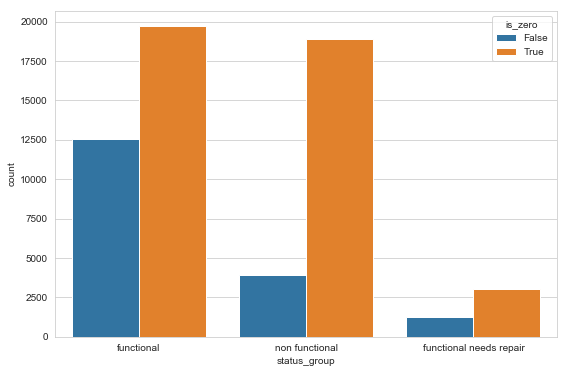

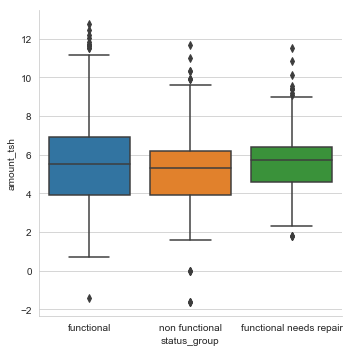

In [94]:
eda_numerical_variable('amount_tsh', 'log')

#### gps_height
This is the altitude of the well.  
Label *functional needs repair* may be underrepresented for altitude below 750. 

NUMERICAL VARIABLE: gps_height
percentage of 0 value = 34.41%

Distribution of label values for predictor with NON-ZERO value


functional                 0.559263
non functional             0.375186
functional needs repair    0.065551
Name: status_group, dtype: float64

Distribution of label values for predictor with ZERO value


functional                 0.512232
non functional             0.401507
functional needs repair    0.086261
Name: status_group, dtype: float64

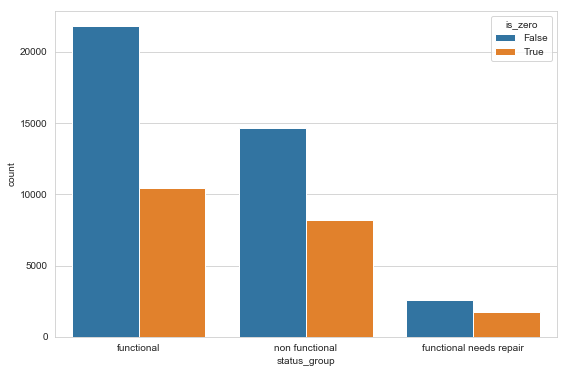

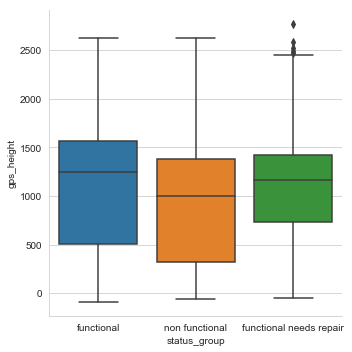

In [96]:
eda_numerical_variable('gps_height')

#### longitude
Some missing value. Higher frequency of *functional needs repair* status for missing value. 

NUMERICAL VARIABLE: longitude
percentage of 0 value = 3.05%

Distribution of label values for predictor with NON-ZERO value


functional                 0.545061
non functional             0.386678
functional needs repair    0.068261
Name: status_group, dtype: float64

Distribution of label values for predictor with ZERO value


functional                 0.480132
non functional             0.306843
functional needs repair    0.213024
Name: status_group, dtype: float64

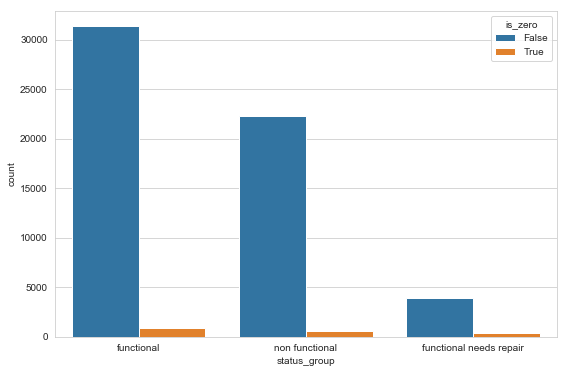

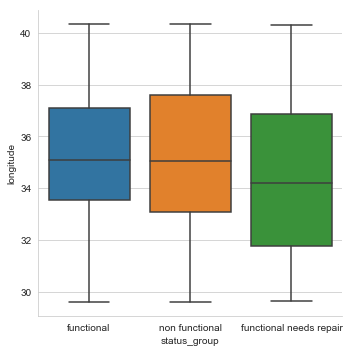

In [97]:
eda_numerical_variable('longitude')

#### latitude
no missing value and not obvious correlation with label. We will drop it.

NUMERICAL VARIABLE: latitude
percentage of 0 value = 0.00%

Distribution of label values for predictor with NON-ZERO value


functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

Distribution of label values for predictor with ZERO value


Series([], Name: status_group, dtype: float64)

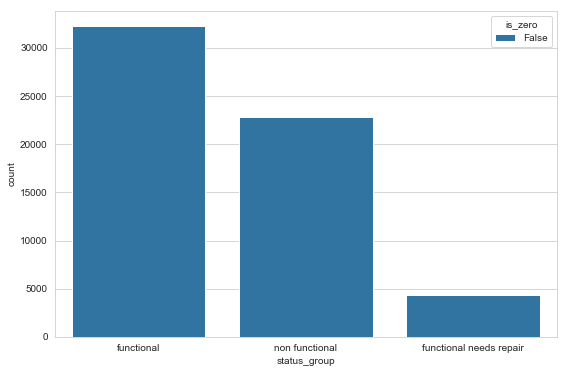

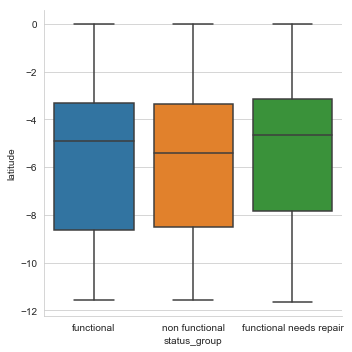

In [98]:
eda_numerical_variable('latitude')

#### num_private
meaning unknown. Very high frequency of 0 value. Drop or treat as categorical.

NUMERICAL VARIABLE: num_private
percentage of 0 value = 98.73%

Distribution of label values for predictor with NON-ZERO value


functional                 0.608983
non functional             0.327609
functional needs repair    0.063408
Name: status_group, dtype: float64

Distribution of label values for predictor with ZERO value


functional                 0.542230
non functional             0.384973
functional needs repair    0.072796
Name: status_group, dtype: float64

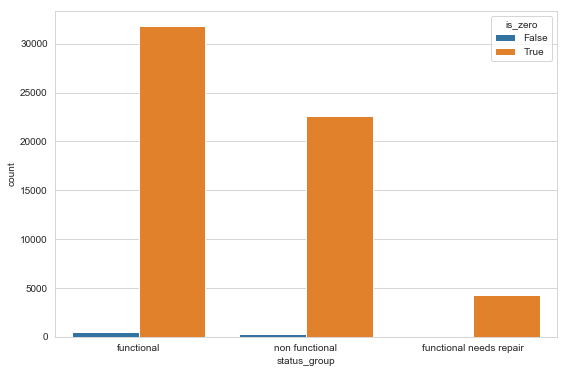

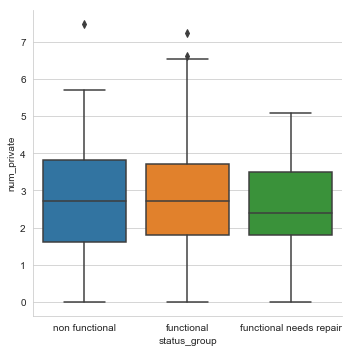

In [99]:
eda_numerical_variable('num_private', 'log')

#### region_code and district_code
* region_code - Geographic location (coded)
* district_code - Geographic location (coded)
Numerical values but unordered. Process as categorical variables.

#### population
no impact of missing/valid value  


NUMERICAL VARIABLE: population
percentage of 0 value = 35.99%

Distribution of label values for predictor with NON-ZERO value


functional                 0.551961
non functional             0.381178
functional needs repair    0.066861
Name: status_group, dtype: float64

Distribution of label values for predictor with ZERO value


functional                 0.527291
non functional             0.389692
functional needs repair    0.083018
Name: status_group, dtype: float64

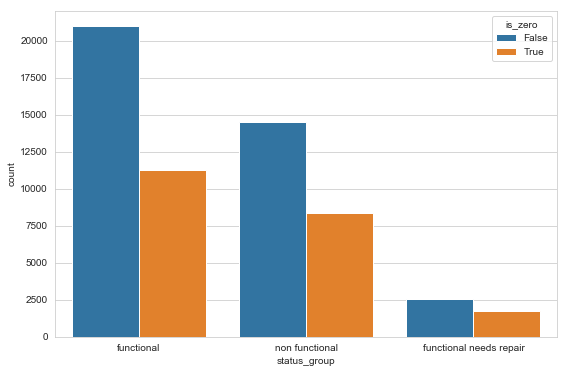

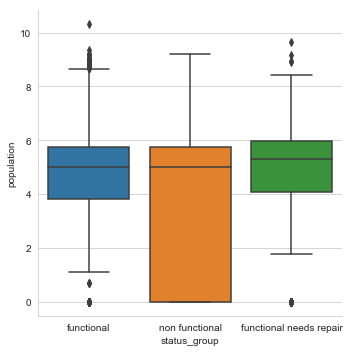

In [100]:
eda_numerical_variable('population', 'log')

### Categorical variables

## Feature Engineering

This dataset contains several categorical variables with very high cardinality, like for example *funder* with 1897 unique values. There are 3 approaches possible to handle this type of features:
* group together values that have close meaning (this is however not possible for variables like *funder* for which there is no clear proximity measure between different values)
* discard values with low frequencies (possible, but this would probably be unsufficient to reduce enough the number of unique values)
* **transform the initial feature into a continuous numerical feature**  

We will use option 3, and we define 3 functions $f_F$, $f_R$ and $f_N$:
$$f_F(x) = \frac{N_F(x) + p_F}{N(x) + 1}$$  
$$f_R(x) = \frac{N_R(x) + p_R}{N(x) + 1}$$  
$$f_N(x) = \frac{N_N(x) + p_N}{N(x) + 1}$$ 
where:
* $x$ is a given value of the high cardinality variable V, 
* $N_F(x)$, $N_R(x)$ and $f_N(x)$ are the number of observations with V=x and respectively equal to Functional, Repair, and Non Functional 
* $N(x)$ is the total number of observations with V=X, with $N(x) = N_F(x) + N_R(x) + f_N(x)$
* $p_F$, $p_R$ and $p_N$ are the frequencies over the full set of status Functional, Repair, and Non Functional  
  
Now, it is easy to see that the sum of $f_F$, $f_R$ and $f_N$ is equal to 1 and that these 3 functions can be considered as probabilities of each status: 
$$f_F(x) + f_R(x) + f_N(x) = \frac{N_F(x) + p_F + N_R(x) + p_R + N_N(x) + p_N}{N(x) + 1}
= \frac{N_F(x) + N_R(x) + N_N(x) + p_F + p_R + p_N}{N(x) + 1} = \frac{N(x) + 1}{N(x) + 1}$$  

The rationale for these functions is:
* their value gets closer to the observed frequencies $\frac{N_F(x)}{N(x)}$ as the number of observations $N(x)$ increases. Thus they are putting more weight on frequent values 
* they have an intuitive meaning as estimation of probabilities
* they are defined even if the value x is not included in the training set  

In [78]:
# define transformer to transform high cardinality variables to numerical functions

class HighCardinalityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._frequencies = {}
        self._mapper = {}
        pass
    
    def fit(self, X, y):
        # both X and y must be DF
    
        # compute frequencies over full data
        self._default_frequencies = {}
        for status in ['functional', 'functional needs repair', 'non functional']: 
            self._frequencies[status] = np.count_nonzero(y == status) / y.shape[0]  
        
        # get list of all columns in X 
        columns_to_map = list(X)
        
        self._mapper = {}
        for col in columns_to_map:
            # create df with one variable to map and label
            df = pd.concat([X[col],y], axis=1)
            df.rename(columns={y.columns.values[0]: 'y'}, inplace=True)
            
            # replace y with 3 columns 'y_functional', 'y_functional needs repair', 'y_non functional' with counts 
            df = pd.get_dummies(data=df, columns=['y'])
            df = df.groupby(col).sum()
            df['count'] = df['y_functional'] +  df['y_functional needs repair'] + df['y_non functional']
            # calculate the 3 probability estimates
            df['functional'] = (df['y_functional'] + self._frequencies['functional']) / (df['count'] + 1)
            df['functional needs repair'] = (df['y_functional needs repair'] + self._frequencies['functional needs repair']) / (df['count'] + 1)
            df['non functional'] = (df['y_non functional'] + self._frequencies['non functional']) / (df['count'] + 1) 

            # create mapper with format:
            #     {'col1': {'functional': {val1: f1, val2: f2, ...},
            #               'functional needs repair': {val1: f1, val2: f2, ...},
            #               'non functional': {val1: f1, val2: f2, ...}}, 
            #      'col2': ...}
            self._mapper[col] = df[['functional', 'functional needs repair', 'non functional']].to_dict()
            
        return self
    
    def transform(self, X, y=None):
        res = X.copy()
        
        col_name = 'lga'
        for col_name in list(X):
            for y_name in ['functional', 'functional needs repair', 'non functional']: 
                mapper = self._mapper[col_name][y_name]
                new_col = col_name + '_f_' + y_name
                res[new_col] = X[col_name].map(mapper)
                
                # fill NA value with frequency of corresponding status - TODO not tested 
                res[new_col] = res[new_col].fillna(value=self._frequencies[y_name])
                
        return res
    
    def get_frequencies(self):        
        return self._frequencies
    
    def get_mapper(self):
        return self._mapper   
    
# example: transform 2 categorical values to numeric functions    
hct = HighCardinalityTransformer()
hct.fit(train_predictors[['region','lga']], train_target[['status_group']])
res = hct.transform(train_predictors[['region','lga']])
res.head(10)

HighCardinalityTransformer()

,region,lga,region_f_functional,region_f_functional needs repair,region_f_non functional,lga_f_functional,lga_f_functional needs repair,lga_f_non functional
0,Iringa,Ludewa,0.782161,0.023243,0.194596,0.774413,0.019598,0.205990
1,Mara,Serengeti,0.450022,0.030494,0.519484,0.592110,0.037758,0.370131
2,Manyara,Simanjiro,0.623449,0.060652,0.315899,0.581046,0.016416,0.402538
3,Mtwara,Nanyumbu,0.303029,0.072832,0.624139,0.267567,0.000457,0.731976
4,Kagera,Karagwe,0.520815,0.091671,0.387514,0.530496,0.058384,0.411119
5,Tanga,Mkinga,0.563792,0.028678,0.407529,0.776966,0.000251,0.222783
6,Shinyanga,Shinyanga Rural,0.559812,0.127448,0.312740,0.564589,0.018799,0.416612
7,Shinyanga,Kahama,0.559812,0.127448,0.312740,0.552620,0.004866,0.442514
8,Tabora,Tabora Urban,0.432930,0.022996,0.544074,0.349635,0.000466,0.649899
9,Kagera,Karagwe,0.520815,0.091671,0.387514,0.530496,0.058384,0.411119
